<a href="https://colab.research.google.com/github/lgiesen/forest-height/blob/main/notbooks/BoostedTreeNNr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data load

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!unzip gdrive/My\ Drive/DataDa2/images_train.zip

In [ ]:
!unzip gdrive/My\ Drive/DataDa2/masks_train.zip

In [5]:
import numpy as np
import pandas as pd
import datetime, os, cv2
from matplotlib import pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import TensorBoard

In [6]:
data = np.empty((0,11))
for i in range(20):
  if i < 10:
    X = np.load('/content/images/image_00'+ str(i) + '.npy')
    y = np.load('/content/masks/mask_00'+ str(i) + '.npy')
    X = X.reshape(10, -1)
    y = y.reshape(1, -1)
    Xy = np.concatenate((X, y), axis=0)
    Xy = Xy.transpose()
    # Concatenate the arrays along the first axis (number of features)
    data = np.concatenate((data, Xy), axis=0)
  if i >= 10:
    X = np.load('/content/images/image_0'+ str(i) + '.npy')
    y = np.load('/content/masks/mask_0'+ str(i) + '.npy')
    X = X.reshape(10, -1)
    y = y.reshape(1, -1)
    Xy = np.concatenate((X, y), axis=0)
    Xy = Xy.transpose()
    # Concatenate the arrays along the first axis (number of features)
    data = np.concatenate((data, Xy), axis=0)

num = np.count_nonzero(data[:,10])
indices = np.nonzero(data[:,-1])

labeled_data = data[indices]

df = pd.DataFrame(labeled_data)
df.columns = ['B2', 'B3','B4', 'B5','B6', 'B7','B8', 'B8A','B11', 'B12', "Label"]

print(df)

          B2      B3      B4      B5      B6      B7      B8     B8A     B11  \
0      217.0   407.0   233.0   603.0  1574.0  1885.0  2150.0  2036.0  1013.0   
1      233.0   317.0   238.0   519.0  1297.0  1575.0  1581.0  1684.0   732.0   
2      157.0   287.0   215.0   513.0  1300.0  1545.0  1381.0  1720.0   839.0   
3      220.0   351.0   268.0   611.0  1505.0  1792.0  1844.0  2028.0   935.0   
4      254.0   408.0   314.0   844.0  2078.0  2472.0  2202.0  2689.0  1263.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
32234  220.0   313.0   236.0   500.0  1241.0  1564.0  1711.0  1757.0   774.0   
32235  361.0   490.0   365.0   655.0  1828.0  2184.0  2423.0  2334.0  1096.0   
32236  395.0   538.0   336.0   799.0  2332.0  2793.0  2790.0  2988.0  1409.0   
32237  346.0   491.0   348.0   854.0  2512.0  3052.0  2986.0  3333.0  1764.0   
32238  831.0  1060.0  1232.0  1342.0  2593.0  2970.0  2920.0  3208.0  2482.0   

          B12      Label  
0       515.

### Create train and test set

In [7]:
features = df.iloc[:, 0:10]
labels = df.iloc[:,10]

Xtrain, Xtest, ytrain, ytest = train_test_split(features, labels , test_size = 0.3, random_state=3)

In [235]:
Xtrain, Xtest, ytrain, ytest = train_test_split(features, labels , test_size = 0.3, random_state=3)

### Boosted Tree

In [229]:
dtr = GradientBoostingRegressor(n_estimators = 150, max_depth= 1, random_state=1)

dtr.fit(Xtrain, ytrain)

ypred_dtr = dtr.predict(Xtest)

mse_dtr = mse(ytest, ypred_dtr)

rmse_dtr = mse_dtr ** (1/2)

mae_dtr = mae(ytest, ypred_dtr)

mape_dtr = mape(ytest, ypred_dtr)

print(mape_dtr)

print(mae_dtr)

print(rmse_dtr)

0.730674427432311
5.000268862753485
7.338836027061891


### Neural Network

In [ ]:
%load_ext tensorboard

In [ ]:
model = Sequential()
model.add(Dense(100, input_shape=(10,), kernel_initializer='normal', activation='relu'))
model.add(Dense(50, kernel_initializer='normal', activation='relu'))
model.add(Dense(25, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))

model.summary()

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

model.fit(Xtrain, ytrain, epochs = 1000, validation_data=(Xtest, ytest), callbacks=[tensorboard_callback])

In [244]:
ypred_nn = model.predict(Xtest)

mse_nn = mse(ytest, ypred_nn)

rmse_nn = mse_dtr ** (1/2)

mae_nn = mae(ytest, ypred_nn)

mape_nn = mape(ytest, ypred_nn)

print(mape_nn)

print(mae_nn)

print(rmse_nn)

10/10 [==============================] - 0s 3ms/step
0.7849136720140398
6.046900163194548
7.338836027061891


In [ ]:
%tensorboard --logdir logs

### Random forest

In [230]:
rf = RandomForestRegressor(n_estimators = 400, min_samples_leaf= 0.04, random_state=1)

rf.fit(Xtrain, ytrain)

ypred_rf = rf.predict(Xtest)

mse_rf = mse(ytest, ypred_rf)

rmse_rf = mse_rf ** (1/2)

mae_rf = mae(ytest, ypred_rf)

mape_rf = mape(ytest, ypred_rf)

print(mape_rf)

print(mae_rf)

print(rmse_rf)

0.7426920620896985
5.053243475153481
7.427116704108982


### Evaluate statitics of the test set predictions

In [246]:
mean_nn = np.mean(ypred_nn[:])
mean_bt = np.mean(t2pred[:])
mean_rf = np.mean(ypred_rf[:])
mean_labels = np.mean(labels[:])

quantiles_nn = np.percentile(ypred_nn[:], [1, 25, 50, 75, 99])
quantiles_bt = np.percentile(ypred_dtr[:], [1, 25, 50, 75, 99])
quantiles_rf = np.percentile(ypred_rf[:], [1, 25, 50, 75, 99])
quantiles_labels = np.percentile(labels[:], [1, 25, 50, 75, 99])

print(mean_nn)
print(quantiles_nn)
print(mean_bt)
print(quantiles_bt)
print(mean_rf)
print(quantiles_rf)
print(mean_labels)
print(quantiles_labels)

11.280124
[ 2.11866269  3.46965241  5.91826248 19.80651283 33.95022659]
14.242994434135746
[ 3.55542017  4.80136607  7.3502046  20.05094388 26.97271222]
11.57704524676684
[ 3.42387756  4.82015539  9.09812901 19.48148836 25.14383844]
11.417272737772779
[ 2.3900001   2.78999996  4.55500007 19.94999933 39.32580154]


In [247]:
print(np.sort(ypred_nn.flatten())[:10])
print(np.sort(ypred_nn.flatten())[-10:][::-1])
print(np.sort(ypred_dtr.flatten())[:10])
print(np.sort(ypred_dtr.flatten())[-10:][::-1])
print(np.sort(ypred_rf.flatten())[:10])
print(np.sort(ypred_rf.flatten())[-10:][::-1])
print(np.sort(labels.values.flatten())[:10])
print(np.sort(labels.values.flatten())[-10:][::-1])

[1.5133326 1.5238211 1.8548043 2.1296568 2.342375  2.3523133 2.3996212
 2.727156  2.7353494 2.8475707]
[56.17654  37.553555 35.16643  33.89955  33.19085  31.440264 31.247997
 30.723238 30.597174 30.24525 ]
[-0.768323    2.99163917  2.99163917  2.99163917  3.02636275  3.55542017
  3.55542017  3.55542017  3.55542017  3.55542017]
[27.87893258 27.87893258 27.87893258 27.87893258 27.87893258 27.87893258
 27.87893258 27.87893258 27.87893258 27.87893258]
[3.37883112 3.37883112 3.37883112 3.37937474 3.37974126 3.37974126
 3.38004652 3.38004652 3.38004652 3.38004652]
[25.14383844 25.14383844 25.14383844 25.14383844 25.14383844 25.14383844
 25.14383844 25.14383844 25.14383844 25.14383844]
[2.27999997 2.31999993 2.31999993 2.3499999  2.3499999  2.38000011
 2.38000011 2.3900001  2.3900001  2.3900001 ]
[81.69000244 58.63000107 44.90999985 44.47999954 43.47000122 42.66999817
 42.34000015 41.93000031 40.47000122 40.02000046]


### Load single image

In [ ]:
X = np.load('/content/images/image_000.npy')
y = np.load('/content/masks/mask_000.npy')

y.shape
X.shape
Xr = X.reshape(10,-1).transpose()

### Predict on features of image all the labels of the image

In [251]:
tpred = model.predict(Xr)

32768/32768 [==============================] - 47s 1ms/step


In [162]:
pXr = pd.DataFrame(Xr)
pXr.columns = ['B2', 'B3','B4', 'B5','B6', 'B7','B8', 'B8A','B11', 'B12']
t2pred = dtr.predict(pXr)

In [191]:
t3pred = rf.predict(pXr)

### Evaluate statistics of labels and predictions

In [252]:
mean_nn = np.mean(tpred[:])
mean_bt = np.mean(t2pred[:])
mean_rf = np.mean(t3pred[:])
mean_labels = np.mean(labels[:])

quantiles_nn = np.percentile(tpred[:], [1, 25, 50, 75, 99])
quantiles_bt = np.percentile(t2pred[:], [1, 25, 50, 75, 99])
quantiles_rf = np.percentile(t3pred[:], [1, 25, 50, 75, 99])
quantiles_labels = np.percentile(labels[:], [1, 25, 50, 75, 99])

print(mean_nn)
print(quantiles_nn)
print(mean_bt)
print(quantiles_bt)
print(mean_rf)
print(quantiles_rf)
print(mean_labels)
print(quantiles_labels)

13.414936
[ 1.87270224  5.91638446 10.36382771 19.33285761 40.31981182]
14.242994434135746
[ 3.83136925  6.39159973 12.32081624 21.7044219  27.87893258]
13.637859212260063
[ 3.60543348  6.23456071 10.32691205 21.22342616 25.14383844]
11.417272737772779
[ 2.3900001   2.78999996  4.55500007 19.94999933 39.32580154]


In [253]:
print(np.min(tpred[:]))
print(np.max(tpred[:]))
print(np.min(t2pred[:]))
print(np.max(t2pred[:]))
print(np.min(t3pred[:]))
print(np.max(t3pred[:]))
print(np.min(labels[:]))
print(np.max(labels[:]))

-20.642174
68.45557
-7.457369563390162
27.87893257665513
3.3788311225824184
25.14383843606116
2.2799999713897705
81.69000244140625


In [254]:
print(np.sort(tpred.flatten())[:10])
print(np.sort(tpred.flatten())[-10:][::-1])
print(np.sort(t2pred.flatten())[:10])
print(np.sort(t2pred.flatten())[-10:][::-1])
print(np.sort(t3pred.flatten())[:10])
print(np.sort(t3pred.flatten())[-10:][::-1])
print(np.sort(labels.values.flatten())[:10])
print(np.sort(labels.values.flatten())[-10:][::-1])

[-20.642174 -17.846302 -17.28912  -16.99687  -16.973486 -16.84247
 -16.473095 -16.311117 -16.280672 -15.969859]
[68.45557  67.6318   67.569275 67.56571  67.46666  66.96146  66.89169
 66.85608  66.82329  66.694466]
[-7.45736956 -7.06872291 -7.06872291 -7.06872291 -6.73824905 -6.1176384
 -6.08490972 -5.99135651 -5.70530481 -5.70530481]
[27.87893258 27.87893258 27.87893258 27.87893258 27.87893258 27.87893258
 27.87893258 27.87893258 27.87893258 27.87893258]
[3.37883112 3.37883112 3.37965261 3.37974126 3.37974126 3.38004652
 3.38004652 3.38004652 3.38004652 3.38004652]
[25.14383844 25.14383844 25.14383844 25.14383844 25.14383844 25.14383844
 25.14383844 25.14383844 25.14383844 25.14383844]
[2.27999997 2.31999993 2.31999993 2.3499999  2.3499999  2.38000011
 2.38000011 2.3900001  2.3900001  2.3900001 ]
[81.69000244 58.63000107 44.90999985 44.47999954 43.47000122 42.66999817
 42.34000015 41.93000031 40.47000122 40.02000046]


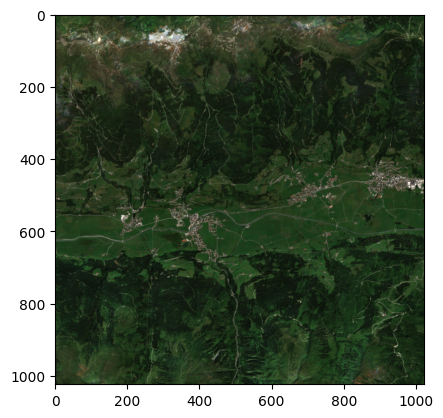

In [227]:
 plt.imshow(np.load("/content/images/image_000.npy")[[2,1,0]].transpose(1,2,0)/3000)

### Create balanced data set

In [ ]:
df1 = df.iloc[0:8,]
df93 = df.iloc[331:18000,].sample(330)
df99 = df.iloc[18001:32239,].sample(330)

frames = [df59, df93, df99]

result = pd.concat(frames)
print(result)


features = result.iloc[:, 0:10]
labels = result.iloc[:,10]

In [317]:
dfquant = df.groupby((df['Label'])//5)['Label'].count()
print(dfquant)

Label
0.0     15829
1.0      3288
2.0      2095
3.0      2710
4.0      3235
5.0      2737
6.0      1553
7.0       564
8.0       165
9.0        41
10.0       15
11.0        4
12.0        1
13.0        1
16.0        1
Name: Label, dtype: int64


In [303]:
df

,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12,Label
0,217.0,407.0,233.0,603.0,1574.0,1885.0,2150.0,2036.0,1013.0,515.0,27.389999
1,233.0,317.0,238.0,519.0,1297.0,1575.0,1581.0,1684.0,732.0,387.0,27.200001
2,157.0,287.0,215.0,513.0,1300.0,1545.0,1381.0,1720.0,839.0,457.0,25.450001
3,220.0,351.0,268.0,611.0,1505.0,1792.0,1844.0,2028.0,935.0,502.0,30.190001
4,254.0,408.0,314.0,844.0,2078.0,2472.0,2202.0,2689.0,1263.0,654.0,44.480000
...,...,...,...,...,...,...,...,...,...,...,...
32234,220.0,313.0,236.0,500.0,1241.0,1564.0,1711.0,1757.0,774.0,362.0,37.380001
32235,361.0,490.0,365.0,655.0,1828.0,2184.0,2423.0,2334.0,1096.0,585.0,23.750000
32236,395.0,538.0,336.0,799.0,2332.0,2793.0,2790.0,2988.0,1409.0,703.0,31.990000
32237,346.0,491.0,348.0,854.0,2512.0,3052.0,2986.0,3333.0,1764.0,928.0,28.730000


In [33]:
dfs = df.sort_values('Label').reset_index(drop=True)
print(dfs)


           B2      B3      B4      B5      B6      B7      B8     B8A     B11  \
0       478.0   599.0   736.0   828.0  1191.0  1382.0  1502.0  1641.0  2033.0   
1       453.0   712.0   626.0  1077.0  2568.0  3161.0  3176.0  3375.0  2017.0   
2       638.0   906.0   824.0  1429.0  2137.0  2415.0  2542.0  2753.0  2338.0   
3       403.0   640.0   398.0  1071.0  2558.0  3016.0  3442.0  3299.0  1504.0   
4       574.0   812.0   823.0  1300.0  3200.0  3777.0  3995.0  4169.0  2320.0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
32234   457.0   766.0   480.0  1173.0  3693.0  4658.0  4872.0  5062.0  2352.0   
32235   176.0   293.0   216.0   626.0  1559.0  1832.0  1636.0  2004.0  1026.0   
32236  1289.0  1440.0  1470.0  2413.0  2391.0  2412.0  1749.0  2393.0  2605.0   
32237   159.0   286.0   154.0   472.0  1595.0  2110.0  2391.0  2242.0  1003.0   
32238   219.0   364.0   250.0   609.0  1597.0  1928.0  1933.0  2091.0   874.0   

          B12      Label  


In [318]:
np.percentile(labels[:], [1, 25, 50, 75, 99])

array([ 2.3900001 ,  2.78999996,  4.55500007, 19.94999933, 39.32580154])

In [9]:
df5 = df[df["Label"] < 5]
print(df5)

          B2      B3      B4      B5      B6      B7      B8     B8A     B11  \
11     418.0   790.0   492.0  1373.0  3493.0  4085.0  4076.0  4403.0  2291.0   
80     447.0   838.0   736.0  1562.0  3707.0  4408.0  4570.0  4875.0  2534.0   
82     350.0   698.0   466.0  1349.0  3284.0  3881.0  4037.0  4302.0  2287.0   
90     937.0  1249.0  1502.0  1813.0  2552.0  2857.0  2970.0  3043.0  2842.0   
91     690.0   978.0  1014.0  1573.0  2961.0  3924.0  4051.0  4181.0  2376.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
32131  258.0   346.0   236.0   579.0  1396.0  1696.0  1618.0  1798.0   909.0   
32146  438.0   738.0   567.0  1262.0  3281.0  4070.0  3906.0  4388.0  2307.0   
32159  592.0   836.0   771.0  1487.0  2316.0  2574.0  2720.0  2789.0  2460.0   
32180  495.0   687.0   610.0  1058.0  2509.0  3125.0  3142.0  3466.0  1887.0   
32193  720.0   951.0   824.0  1571.0  2799.0  3185.0  3674.0  3438.0  2390.0   

          B12  Label  
11     1206.0   

In [58]:
num = (list(range(3, 84, 3)))
for i in num:
  print(str(i-3)+"<"+str(i))
  print(df["Label"][(df["Label"] > i - 3) & (df["Label"] < i)].count())

0<3
9828
3<6
6919
6<9
1875
9<12
1393
12<15
1177
15<18
1458
18<21
1869
21<24
1907
24<27
1905
27<30
1520
30<33
1032
33<36
694
36<39
319
39<42
155
42<45
73
45<48
30
48<51
14
51<54
10
54<57
3
57<60
3
60<63
1
63<66
0
66<69
0
69<72
1
72<75
0
75<78
0
78<81
0


In [78]:
column_names = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'Label']
dff = pd.DataFrame(columns=column_names)

num = (list(range(3, 37, 3)))
index_start = 0
for i in num:
  index_end = index_start + dfs["Label"][(dfs["Label"] > i - 3) & (dfs["Label"] < i)].count()
  samp = dfs[index_start:index_end].sample(690)
  dff = dff.append(samp)
  index_start = index_end

dff = dff.append(dfs[index_start:])

<ipython-input-78-471c13228cf0>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dff = dff.append(samp)
<ipython-input-78-471c13228cf0>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dff = dff.append(samp)
<ipython-input-78-471c13228cf0>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dff = dff.append(samp)
<ipython-input-78-471c13228cf0>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dff = dff.append(samp)
<ipython-input-78-471c13228cf0>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dff = dff.append(samp)
<ipython-input-78-471c13228cf0>:9: 

In [79]:
print(dff)

           B2      B3      B4      B5      B6      B7      B8     B8A     B11  \
2957    782.0  1086.0  1112.0  1771.0  2700.0  3030.0  3170.0  3238.0  2342.0   
1283    347.0   706.0   414.0  1206.0  3455.0  4211.0  4516.0  4467.0  2250.0   
103     637.0   902.0   964.0  1418.0  2140.0  2381.0  2432.0  2674.0  2779.0   
8379    947.0  1404.0  1571.0  2131.0  3011.0  3184.0  3290.0  3368.0  2881.0   
7901    829.0  1137.0  1149.0  1670.0  2575.0  2904.0  3087.0  3200.0  2428.0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
32234   457.0   766.0   480.0  1173.0  3693.0  4658.0  4872.0  5062.0  2352.0   
32235   176.0   293.0   216.0   626.0  1559.0  1832.0  1636.0  2004.0  1026.0   
32236  1289.0  1440.0  1470.0  2413.0  2391.0  2412.0  1749.0  2393.0  2605.0   
32237   159.0   286.0   154.0   472.0  1595.0  2110.0  2391.0  2242.0  1003.0   
32238   219.0   364.0   250.0   609.0  1597.0  1928.0  1933.0  2091.0   874.0   

          B12      Label  


In [83]:
dff.sample(frac=1).reset_index(drop=True)

,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12,Label
0,310.0,464.0,278.0,826.0,3363.0,4637.0,4982.0,5082.0,2013.0,866.0,19.430000
1,350.0,645.0,365.0,1059.0,3545.0,4377.0,4785.0,4768.0,2215.0,1013.0,35.590000
2,199.0,310.0,200.0,467.0,1509.0,1898.0,2003.0,2068.0,728.0,329.0,26.840000
3,307.0,476.0,382.0,950.0,2095.0,2487.0,2600.0,2717.0,2002.0,1383.0,11.250000
4,378.0,596.0,466.0,921.0,2390.0,2969.0,3074.0,3165.0,1561.0,909.0,6.200000
...,...,...,...,...,...,...,...,...,...,...,...
8937,294.0,487.0,438.0,880.0,1675.0,1983.0,2197.0,2203.0,1812.0,1112.0,9.720000
8938,239.0,458.0,210.0,722.0,2559.0,3326.0,3360.0,3391.0,1361.0,701.0,22.100000
8939,614.0,917.0,844.0,1554.0,2808.0,3662.0,3428.0,3815.0,2406.0,2334.0,2.500000
8940,237.0,371.0,237.0,607.0,2113.0,2735.0,2940.0,3062.0,1235.0,537.0,40.959999
